In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd /content/drive/MyDrive/nerf

/content/drive/MyDrive/nerf


In [3]:
import os
import numpy as np
import imageio 
import json
import cv2
import math
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F

In [4]:
trans_t = lambda t : torch.Tensor([
    [1,0,0,0],
    [0,1,0,0],
    [0,0,1,t],
    [0,0,0,1]]).float()

rot_phi = lambda phi : torch.Tensor([
    [1,0,0,0],
    [0,np.cos(phi),-np.sin(phi),0],
    [0,np.sin(phi), np.cos(phi),0],
    [0,0,0,1]]).float()

rot_theta = lambda th : torch.Tensor([
    [np.cos(th),0,-np.sin(th),0],
    [0,1,0,0],
    [np.sin(th),0, np.cos(th),0],
    [0,0,0,1]]).float()


def pose_spherical(theta, phi, radius):
  c2w = trans_t(radius)
  c2w = rot_phi(phi/180.*np.pi) @ c2w
  c2w = rot_theta(theta/180.*np.pi) @ c2w
  c2w = torch.Tensor(np.array([[-1,0,0,0],[0,0,1,0],[0,1,0,0],[0,0,0,1]])) @ c2w
  return c2w


def load_blender_data(basedir, img_size=None, testskip=1):
  splits = ['train', 'val', 'test']
  metas = {}
  for s in splits:
    with open(os.path.join(basedir, 'transforms_{}.json'.format(s)), 'r') as fp:
      metas[s] = json.load(fp)

  all_imgs = []
  all_poses = []
  counts = [0]
  for s in splits:
    meta = metas[s]
    imgs = []
    poses = []
    if s=='train' or testskip==0:
      skip = 1
    else:
      skip = testskip
        
    for frame in meta['frames'][::skip]:
      fname = os.path.join(basedir, frame['file_path'] + '.png')
      imgs.append(imageio.imread(fname))
      poses.append(np.array(frame['transform_matrix']))
    imgs = (np.array(imgs) / 255.).astype(np.float32) # keep all 4 channels (RGBA)
    poses = np.array(poses).astype(np.float32)
    counts.append(counts[-1] + imgs.shape[0])
    all_imgs.append(imgs)
    all_poses.append(poses)
  
  i_split = [np.arange(counts[i], counts[i+1]) for i in range(3)]
  
  imgs = np.concatenate(all_imgs, 0)
  poses = np.concatenate(all_poses, 0)
  
  H, W = imgs[0].shape[:2]
  camera_angle_x = float(meta['camera_angle_x'])
  focal = .5 * W / np.tan(.5 * camera_angle_x)
  
  render_poses = torch.stack([pose_spherical(angle, -30.0, 4.0) for angle in np.linspace(-180,180,40+1)[:-1]], 0)
  
  if img_size!=None:
    scale = min(H,W)/img_size
    H = round(H/scale)
    W = round(W/scale)
    focal = focal/scale

    imgs_temp = np.zeros((imgs.shape[0], img_size, img_size, 4))
    for i, img in enumerate(imgs):
      y = round((H-img_size)/2)
      x = round((W-img_size)/2)
      imgs_temp[i] = cv2.resize(img, (W, H), interpolation=cv2.INTER_AREA)[y:y+H, x:x+W]

    imgs = imgs_temp

      
  return imgs, poses, render_poses, [H, W, focal], i_split



In [5]:
dirs = ["chair", "drums", "ficus", "hotdog", "lego", "materials", "mic", "ship"]
for dir in dirs:
  imgs, poses, render_poses, [H, W, focal], i_split = load_blender_data("./nerf_synthetic/{}".format(dir),64)
  np.savez('./nerf_synthetic/{}-64.npz'.format(dir), imgs=imgs, poses=poses, render_poses=render_poses, hwf=[H, W, focal], i_split=i_split)


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


In [6]:
data = np.load('./nerf_synthetic/drums-64.npz', allow_pickle=True)
imgs = data["imgs"]
poses = data["poses"]
render_poses = data["render_poses"]
[H, W, focal] = data["hwf"]
i_split = data["i_split"]

In [7]:
print(imgs.shape)
print(poses.shape)
print(render_poses.shape)
print([H, W, focal])
print([s.shape for s in i_split])

(400, 64, 64, 4)
(400, 4, 4)
(40, 4, 4)
[64.0, 64.0, 100.0000040333479]
[(100,), (100,), (200,)]


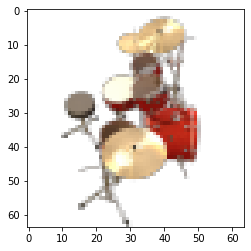

In [8]:
plt.imshow(imgs[1,:,:,:])
plt.show()